Libraries

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

Database Connection

In [8]:
db = mysql.connector.connect(
    host="localhost",
    user="user",
    password="password",
    port="3306",
    database="realestatepredictor"
)

Get Data

In [9]:
# Create a cursor object
cursor = db.cursor()

# Execute the query
cursor.execute("SELECT * FROM homegate")

# Fetch all the records
data = cursor.fetchall()

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['id', 'homegateid', 'price', 'rooms', 'floor', 'livingSpace', 'street', 'latitude', 'longitude', 'locality', 'postalcode'])

# Close the cursor and connection
cursor.close()
db.close()

Null, empty and 0 values

In [10]:
# Calculate the number of rows before dropping NaN values
original_rows = len(df)
print("Number of entries before: ", original_rows)

# Handle null / empty values
df = df.dropna(subset=['price', 'rooms', 'livingSpace', "latitude", "longitude", "postalcode"])

# Remove values 0 from the price and livingSpace columns
df = df[df.price != 0]
df = df[df.livingSpace != 0]

# Calculate the number of rows after dropping NaN values
remaining_rows = len(df)

# Calculate the number of entries deleted
entries_deleted = original_rows - remaining_rows

print("Number of entries deleted: ", entries_deleted)
print("Remaining entries: ", remaining_rows)

Number of entries before:  7817
Number of entries deleted:  1298
Remaining entries:  6519


Outliers

In [11]:
# Define a function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.15)
    Q3 = df[column].quantile(0.85)
    IQR = Q3 - Q1
    df_final = df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]
    return df_final

# Remove outliers from 'price', 'floor' and 'livingSpace'
df = remove_outliers(df, 'price')
df = remove_outliers(df, 'floor')
df = remove_outliers(df, 'livingSpace')

# Calculate the number of rows after removing outliers
final_rows = len(df)

# Calculate the number of outliers removed
outliers_removed = remaining_rows - final_rows

print("Number of entries: ", remaining_rows)
print("Number of outliers deleted: ", outliers_removed)
print("Remaining entries: ", final_rows)

Number of entries:  6519
Number of outliers deleted:  2601
Remaining entries:  3918


Descriptive Statistics

In [12]:
print(df.describe())

                 id         price        rooms        floor  livingSpace  \
count   3918.000000  3.918000e+03  3918.000000  3918.000000  3918.000000   
mean    6417.606942  1.089121e+06     4.008933     2.084992   113.390761   
std     2226.921885  7.135184e+05     1.219699     1.806061    43.557792   
min     2588.000000  1.200000e+05     1.000000    -1.000000    14.000000   
25%     4520.750000  5.927500e+05     3.500000     1.000000    85.000000   
50%     6313.500000  8.650000e+05     4.000000     2.000000   107.000000   
75%     8311.250000  1.380000e+06     4.500000     3.000000   135.000000   
max    10402.000000  4.600000e+06    14.500000    10.000000   289.000000   

          latitude    longitude   postalcode  
count  3918.000000  3918.000000  3918.000000  
mean     46.583061     7.817894  4409.883614  
std       0.538675     0.955151  2625.066846  
min      45.844100     6.080010  1000.000000  
25%      46.179050     6.957160  1870.000000  
50%      46.291300     7.558080  

Visualize Data

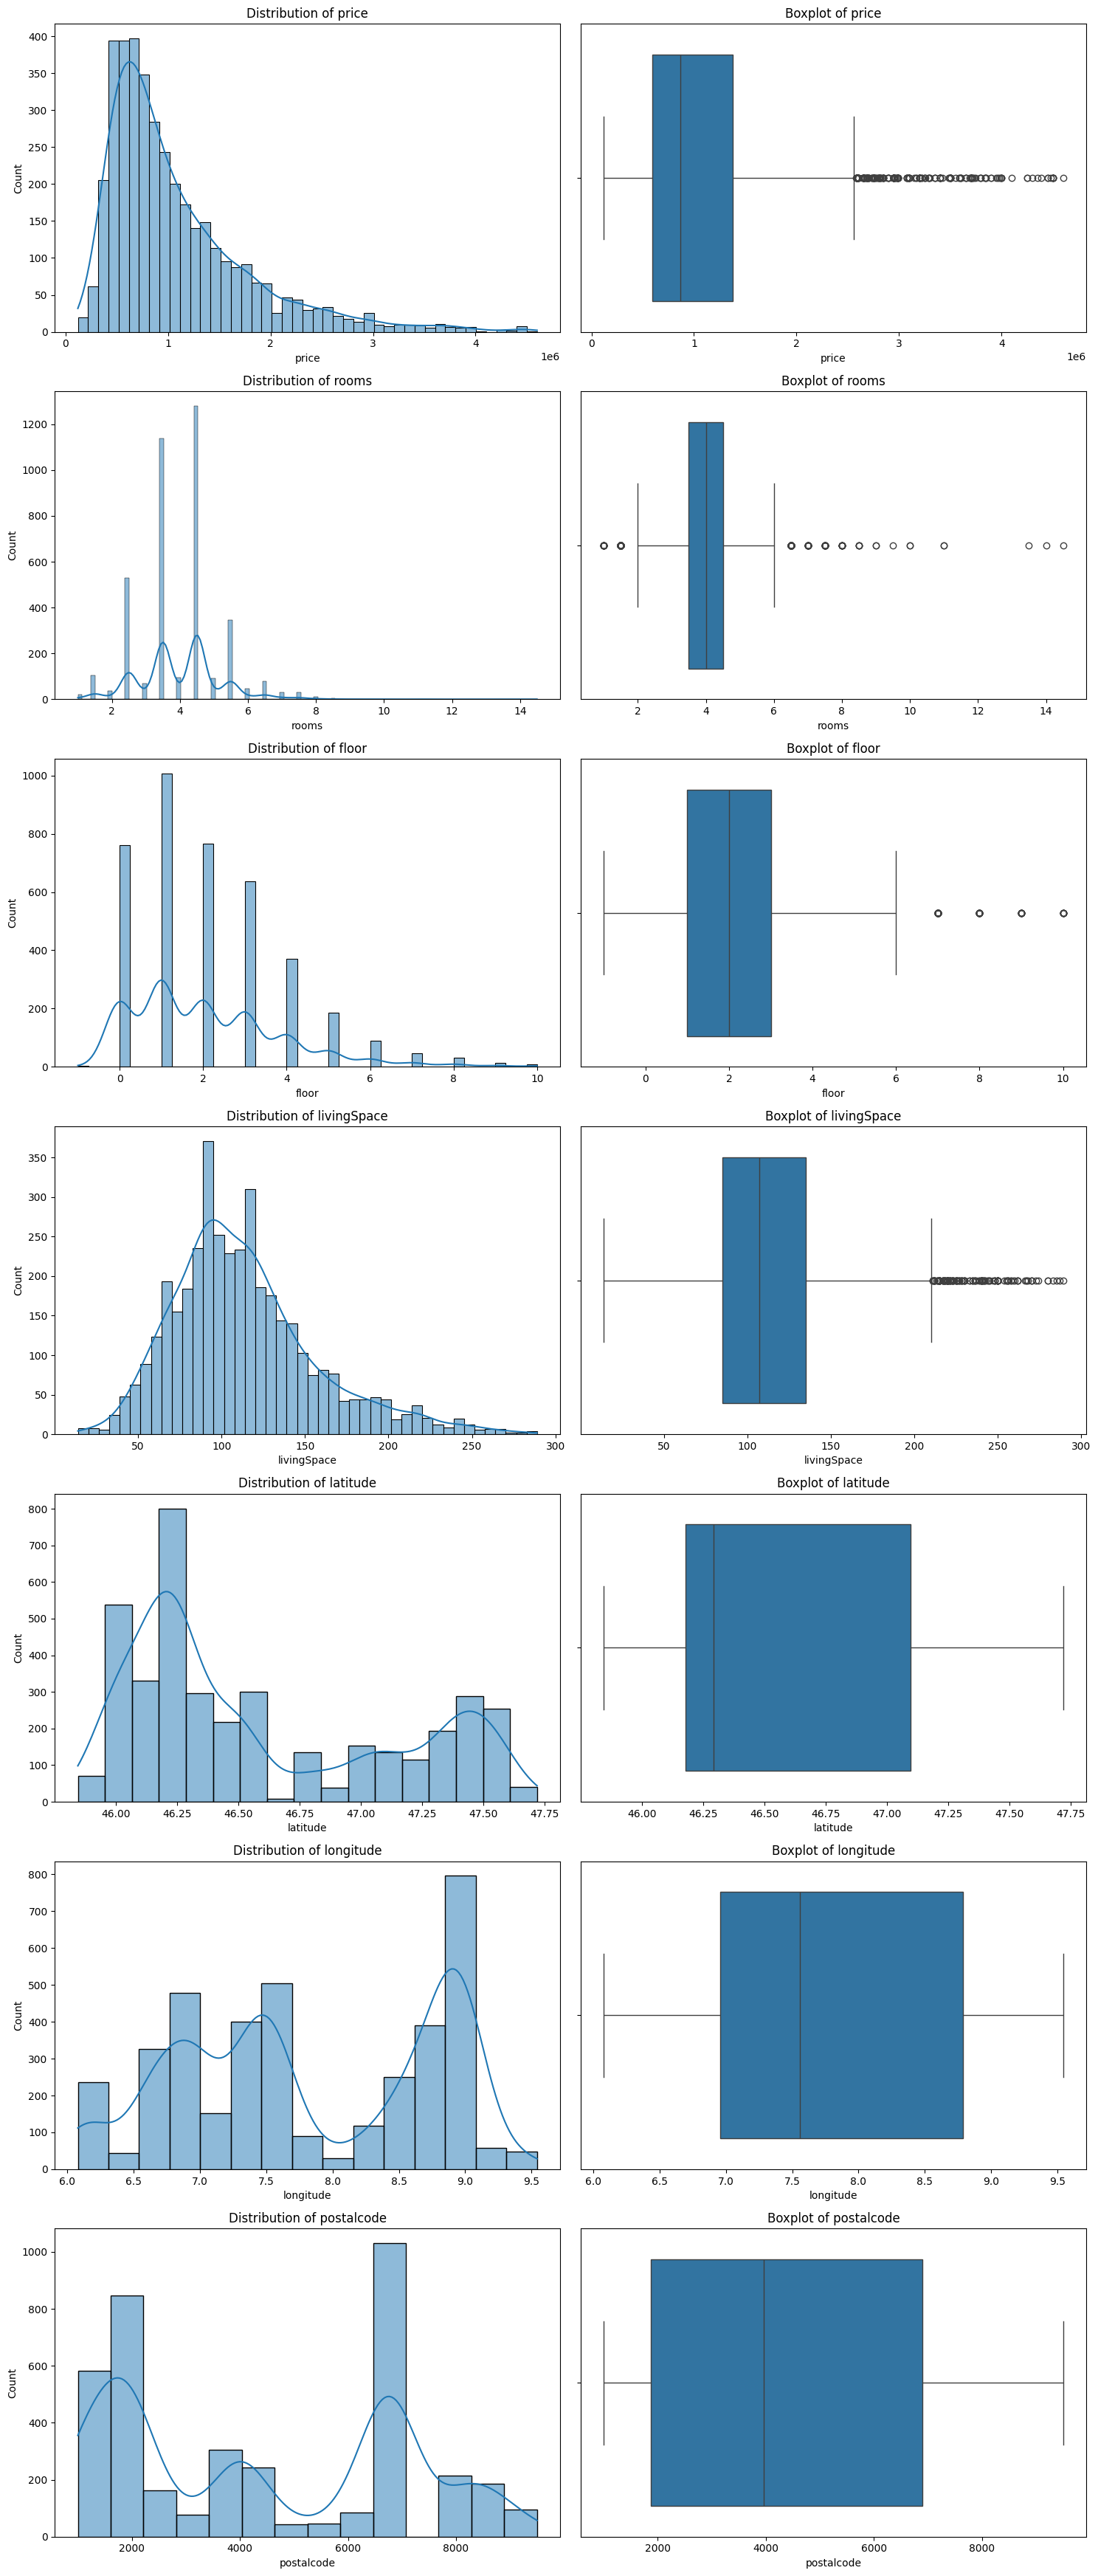

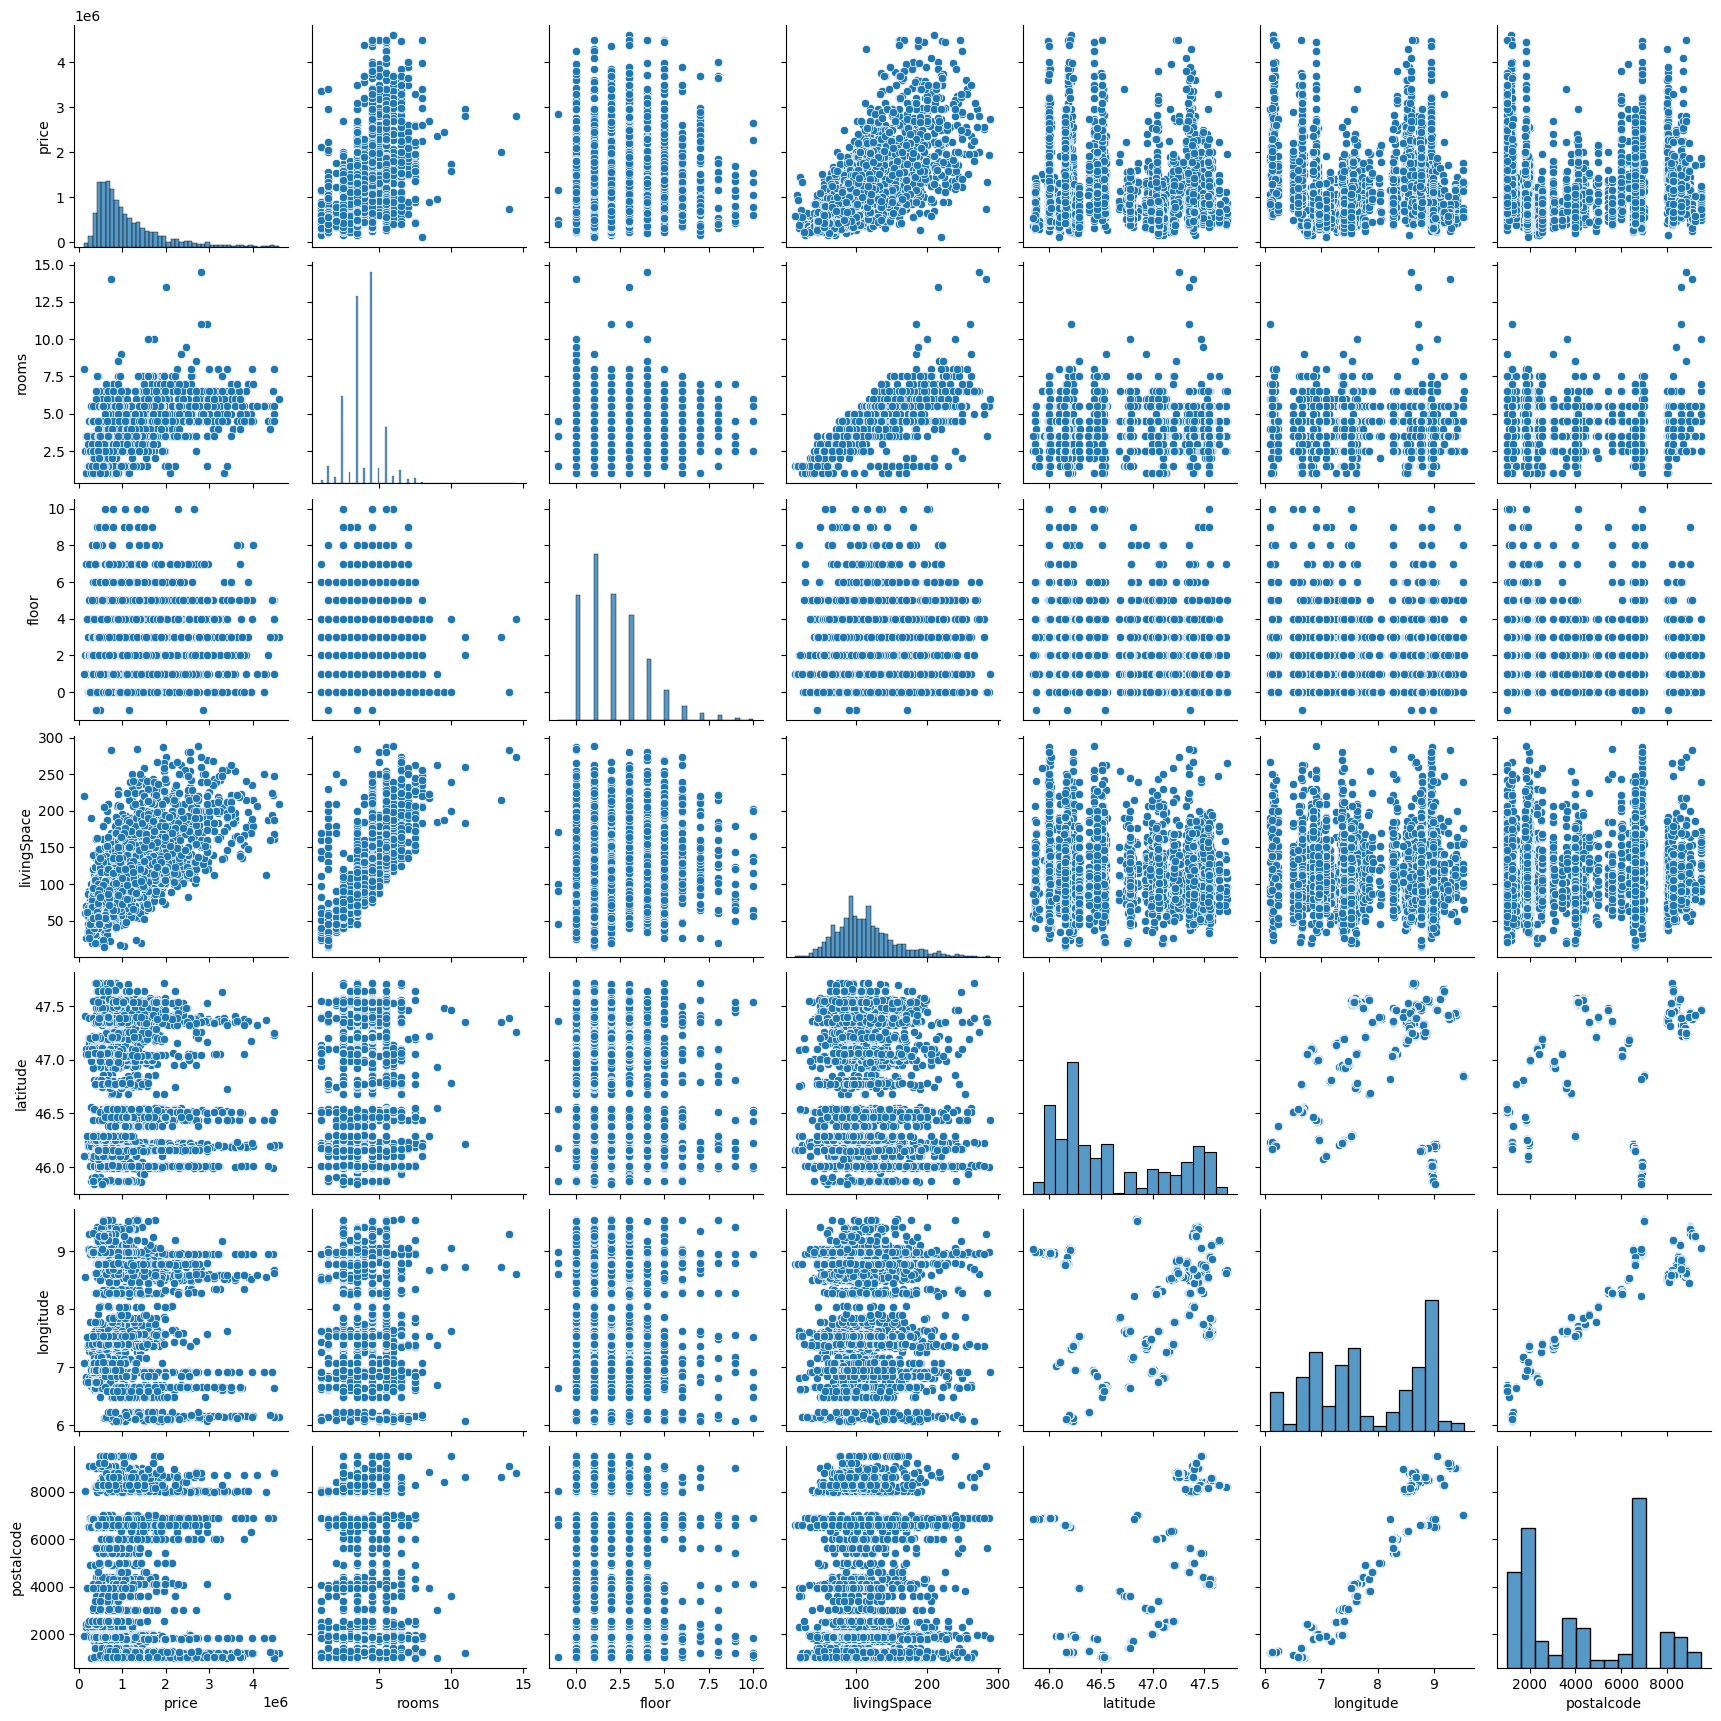

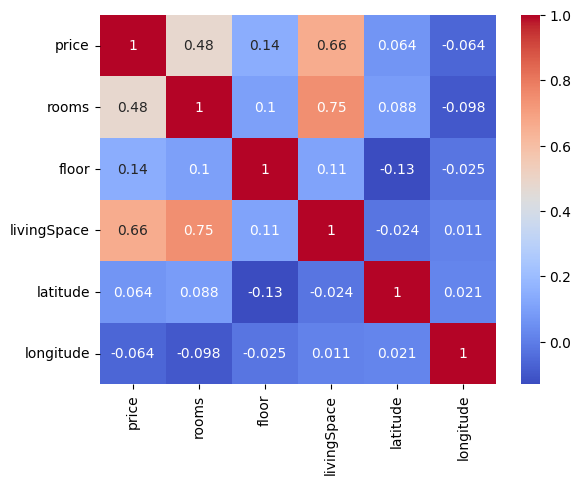

In [13]:
# Get all numeric columns excluding 'ID'
numeric_columns = df.select_dtypes(include=[np.number]).columns.drop('id')

# Create a figure and axes with subplots
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(15, len(numeric_columns)*5))

for i, column in enumerate(numeric_columns):
    # Generate distribution plot for each numeric column
    sns.histplot(df[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {column}")

    # Generate boxplot for each numeric column
    sns.boxplot(x=df[column], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

# Show scatter plots to visualize the data
sns.pairplot(df[['price', 'rooms', 'floor', 'livingSpace', 'street', 'latitude', 'longitude', 'locality', 'postalcode']])
plt.show()

# Show a correlation heatmap
sns.heatmap(df[['price', 'rooms', 'floor', 'livingSpace', 'latitude', 'longitude']].corr(), annot=True, cmap='coolwarm')
plt.show()

GIS

In [14]:
import folium

# Create a map centered around the mean latitude and longitude values
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=8)

# Add a marker for each home to the map
for index, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(m)

# Display the map
m